# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The puddle world domain

Consider the puddleworld domain from the homework, depicted in the figure below.

<img src="puddleworld.png" width="400px">

In it, an all terrain vehicle must navigate a 20 &times; 20 gridworld. The three shaded cells in the upper right corner correspond to the goal state, while the L-shaped shaded cells in the middle of the grid correspond to a puddle in which the vehicle may get stuck and damaged. 

The vehicle has available the standard four actions, _up_, _down_, _left_ and _right_. Each action

* Succeeds and moves the vehicle to the adjacent cell in the corresponding direction with a probability of $0.92$; 
* Fails and moves the vehicle to any of the other 3 adjacent cells with a probability of $0.2$; 
* Fails and the vehicle remains in the same cell with a probability of $0.2$.

The vehicle incurs maximal cost ($1$) for standing in the darker part of the puddle; in the lighter part of the puddle, it incurs a cost of $0.5$. Each movement costs $0.05$ and the goal cells cost $0$.

The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

<IPython.core.display.Javascript object>


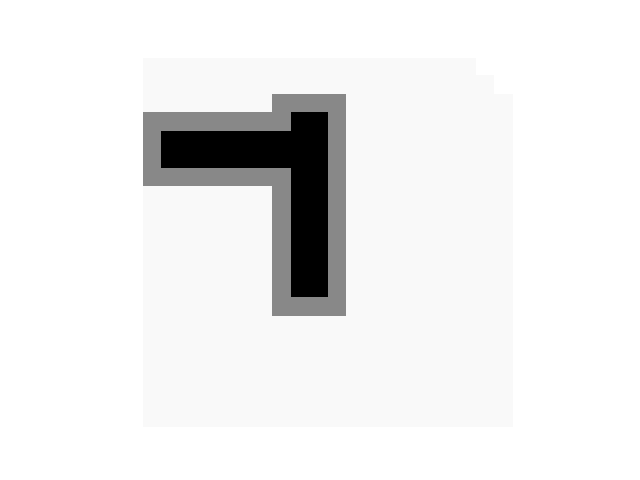

In [3]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Problem specific parameters
GRIDSIZE = 20

def puddlecost(x):
    ''' puddlecost : int -> int

        puddlecost(x) returns the cost for the puddle area corresponding to state x:
        * if x is in the dark puddle area, it returns 1;
        * if x is in the light puddle area, it returns 0.5;
        * otherwise, it returns 0.
        
    '''

    i = x // GRIDSIZE
    j = x % GRIDSIZE
    
    if (j in (4, 5) and i in range(1, 8)) or \
       (i in (8, 9) and j in range(3, 13)):
        return 1.0
    
    if (j in range(3, 7) and i in range(0, 9)) or \
       (i in range(7, 11) and j in range(2, 14)):
        return 0.5
    
    return 0

# -- End: puddlecost


np.set_printoptions(threshold=10)


# States
X = [(i, j) for i in range(GRIDSIZE) for j in range(GRIDSIZE)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities and cost
Pu = np.zeros((nX, nX))
Pd = np.zeros((nX, nX))
Pl = np.zeros((nX, nX))
Pr = np.zeros((nX, nX))

c = np.zeros((nX, nA))

for x in range(nX):
    (i, j) = X[x]
    
    xu = X.index((i, max(j - 1, 0)))
    xd = X.index((i, min(j + 1, GRIDSIZE - 1)))
    xl = X.index((max(i - 1, 0), j))
    xr = X.index((min(i + 1, GRIDSIZE - 1), j))
    
    # Successfull transition
    Pu[x, xu] += 0.92
    Pd[x, xd] += 0.92
    Pl[x, xl] += 0.92
    Pr[x, xr] += 0.92

    # Failed transition (stays in place)
    Pu[x, x] += 0.02
    Pd[x, x] += 0.02
    Pl[x, x] += 0.02
    Pr[x, x] += 0.02

    # Failed transition (oposite direction)
    Pu[x, xd] += 0.02
    Pd[x, xu] += 0.02
    Pl[x, xr] += 0.02
    Pr[x, xl] += 0.02

    # Failed transition (sideways)
    Pu[x, xl] += 0.02
    Pu[x, xr] += 0.02
    Pd[x, xl] += 0.02
    Pd[x, xr] += 0.02
    Pl[x, xu] += 0.02
    Pl[x, xd] += 0.02
    Pr[x, xu] += 0.02
    Pr[x, xd] += 0.02
    
    if x not in (GRIDSIZE * (GRIDSIZE - 2), GRIDSIZE * (GRIDSIZE - 1), GRIDSIZE * (GRIDSIZE - 1) + 1):
        c[x, :] = min(0.05 + puddlecost(x), 1)
    
P = [Pu, Pd, Pl, Pr]

# Discount
gamma = 0.95

# Observe cost function
plt.figure()
plt.imshow(c[:, 0].reshape(GRIDSIZE, GRIDSIZE).T, cmap='Greys', origin='upper')
plt.axis('off')
plt.show()

---

#### Activity 1.        

Compute the optimal $Q$-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [4]:
cu = c[:, 0, None]
cd = c[:, 1, None]
cl = c[:, 2, None]
cr = c[:, 3, None]

err = 1
i = 0
J = np.zeros((400, 1))
Qopt = np.zeros((400, 4))
Q = np.zeros((400, 4))

while err > 1e-8:
    Jnew = np.min(Q, axis=1)
    
    Qu = cu + gamma * Pu.dot(Jnew[:, None])
    Qd = cd + gamma * Pd.dot(Jnew[:, None])
    Ql = cl + gamma * Pl.dot(Jnew[:, None])
    Qr = cr + gamma * Pr.dot(Jnew[:, None])
    Q_new = np.hstack([Qu, Qd, Ql, Qr])
    
    
    err = np.linalg.norm(Q_new - Q)
    i += 1
    J = Jnew
    Q = Q_new


print("iterations = %s\n" % i)
print("Qopt = ")
print(Q)



iterations = 252

Qopt = 
[[0.66620905 0.68217222 0.66620905 0.64867778]
 [0.66785408 0.70889182 0.68381725 0.66734816]
 [0.69667515 1.20781559 0.72174972 0.70663337]
 ...
 [0.60463209 0.64360831 0.63873085 0.62468735]
 [0.62676187 0.6632013  0.65874275 0.64568283]
 [0.64725131 0.66476979 0.67693514 0.66476979]]


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [9]:
e = 0.1
def e_greedy(Q, x):
    p = np.random.choice(2, 1, p = [0.1, 0.9])
    if(p < e):
        return np.random.choice(4, 1)[0]
    else:
        return np.argmin(Q[x, :, None])


#for i in range(0, 20):
#    print(e_greedy(Q, 0))

### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for $500,000$ iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the vehicle to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal $Q$-function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

NameError: name 'N' is not defined

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the $Q$-learning algorithm with a learning rate $\alpha=0.3$.

---

In [28]:
x = 0
a = 0
c = np.zeros((400, 4))

#Pu = Pd = Pl = Pr = np.eye(20)
Q = np.zeros((400, 4))
ql_plot = []
P = [Pu, Pd, Pl, Pr]

def next_state(x, Pa):
    b = np.random.choice(400, 1, p = Pa[x])
    return b[0]

for i in range(0, 500000):
    a = e_greedy(Q, x)
    qt = Q[x, a]
    c[x, :, None] = min(0.05 + puddlecost(x), 1)
    x = next_state(x, P[a])
    next_q = Q[x, :, None]
    
    Qt = qt + 0.3 * (c + 0.95 * np.min(next_q) - qt)
    
    if(i % 500 == 0):
        ql_plot.append( np.linalg.norm(Q - Qt) )
        if(i % 25000 == 0):
            print(i)

    if(x == 400):
        x = np.random.randint(400)
        


0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000


---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

In [29]:
x = 0
a = 0
c = np.zeros((400, 4))

#Pu = Pd = Pl = Pr = np.eye(20)
Q = np.zeros((400, 4))
sarsa_plot = []
P = [Pu, Pd, Pl, Pr]

for i in range(0, 500000):
    a = e_greedy(Q, x)
    qt = Q[x, a]
    c[x, :, None] = min(0.05 + puddlecost(x), 1)
    x = next_state(x, P[a])
    next_q = Q[x, :, None]
    
    Qt = qt + 0.3 * (c + 0.95*(next_q[a]) - qt)
    
    if(i % 500 == 0):
        sarsa_plot.append( np.linalg.norm(Q - Qt) )
        if(i % 25000 == 0):
            print(i)

    if(x == 400):
        x = np.random.randint(400)

0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000


<IPython.core.display.Javascript object>


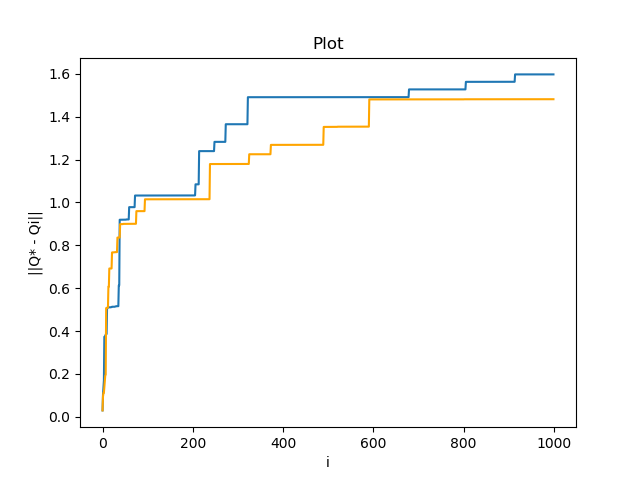

In [36]:
%matplotlib notebook
plt.figure()
plt.plot(ql_plot)
plt.plot(sarsa_plot, color='orange')
plt.title("Plot")
plt.xlabel("i")
plt.ylabel("||Q* - Qi||")
plt.show()

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

In [ ]:
# Insert your comments here.